# kaggle MNIST手寫字辨識
題目：https://www.kaggle.com/c/digit-recognizer/overview<br /><br /><br /><br />
##CNN參考連結：<br />
https://cs231n.github.io/convolutional-networks/<br />
https://ithelp.ithome.com.tw/users/20001976/ironman/1395<br />
https://ithelp.ithome.com.tw/users/20001976/ironman/3128
## kflod for deep learning :<br />
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538<br />
https://www.cnblogs.com/bymo/p/9026198.html
## compute with TPU
https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/classification_iris_data_with_keras.ipynb#scrollTo=2xnX-NTsFQQa
## compute with GPU
https://clay-atlas.com/blog/2019/09/29/colab-chinese-tutorial/

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [47]:
df_ori = pd.read_csv("/content/drive/MyDrive/Colab_Data/MNIST/train.csv")

# data preprocessing

讀入資料並且觀察其標籤分布情形


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


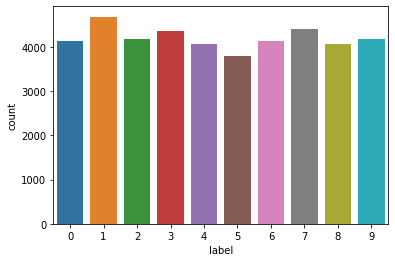

In [48]:
sns.countplot(df_ori["label"])

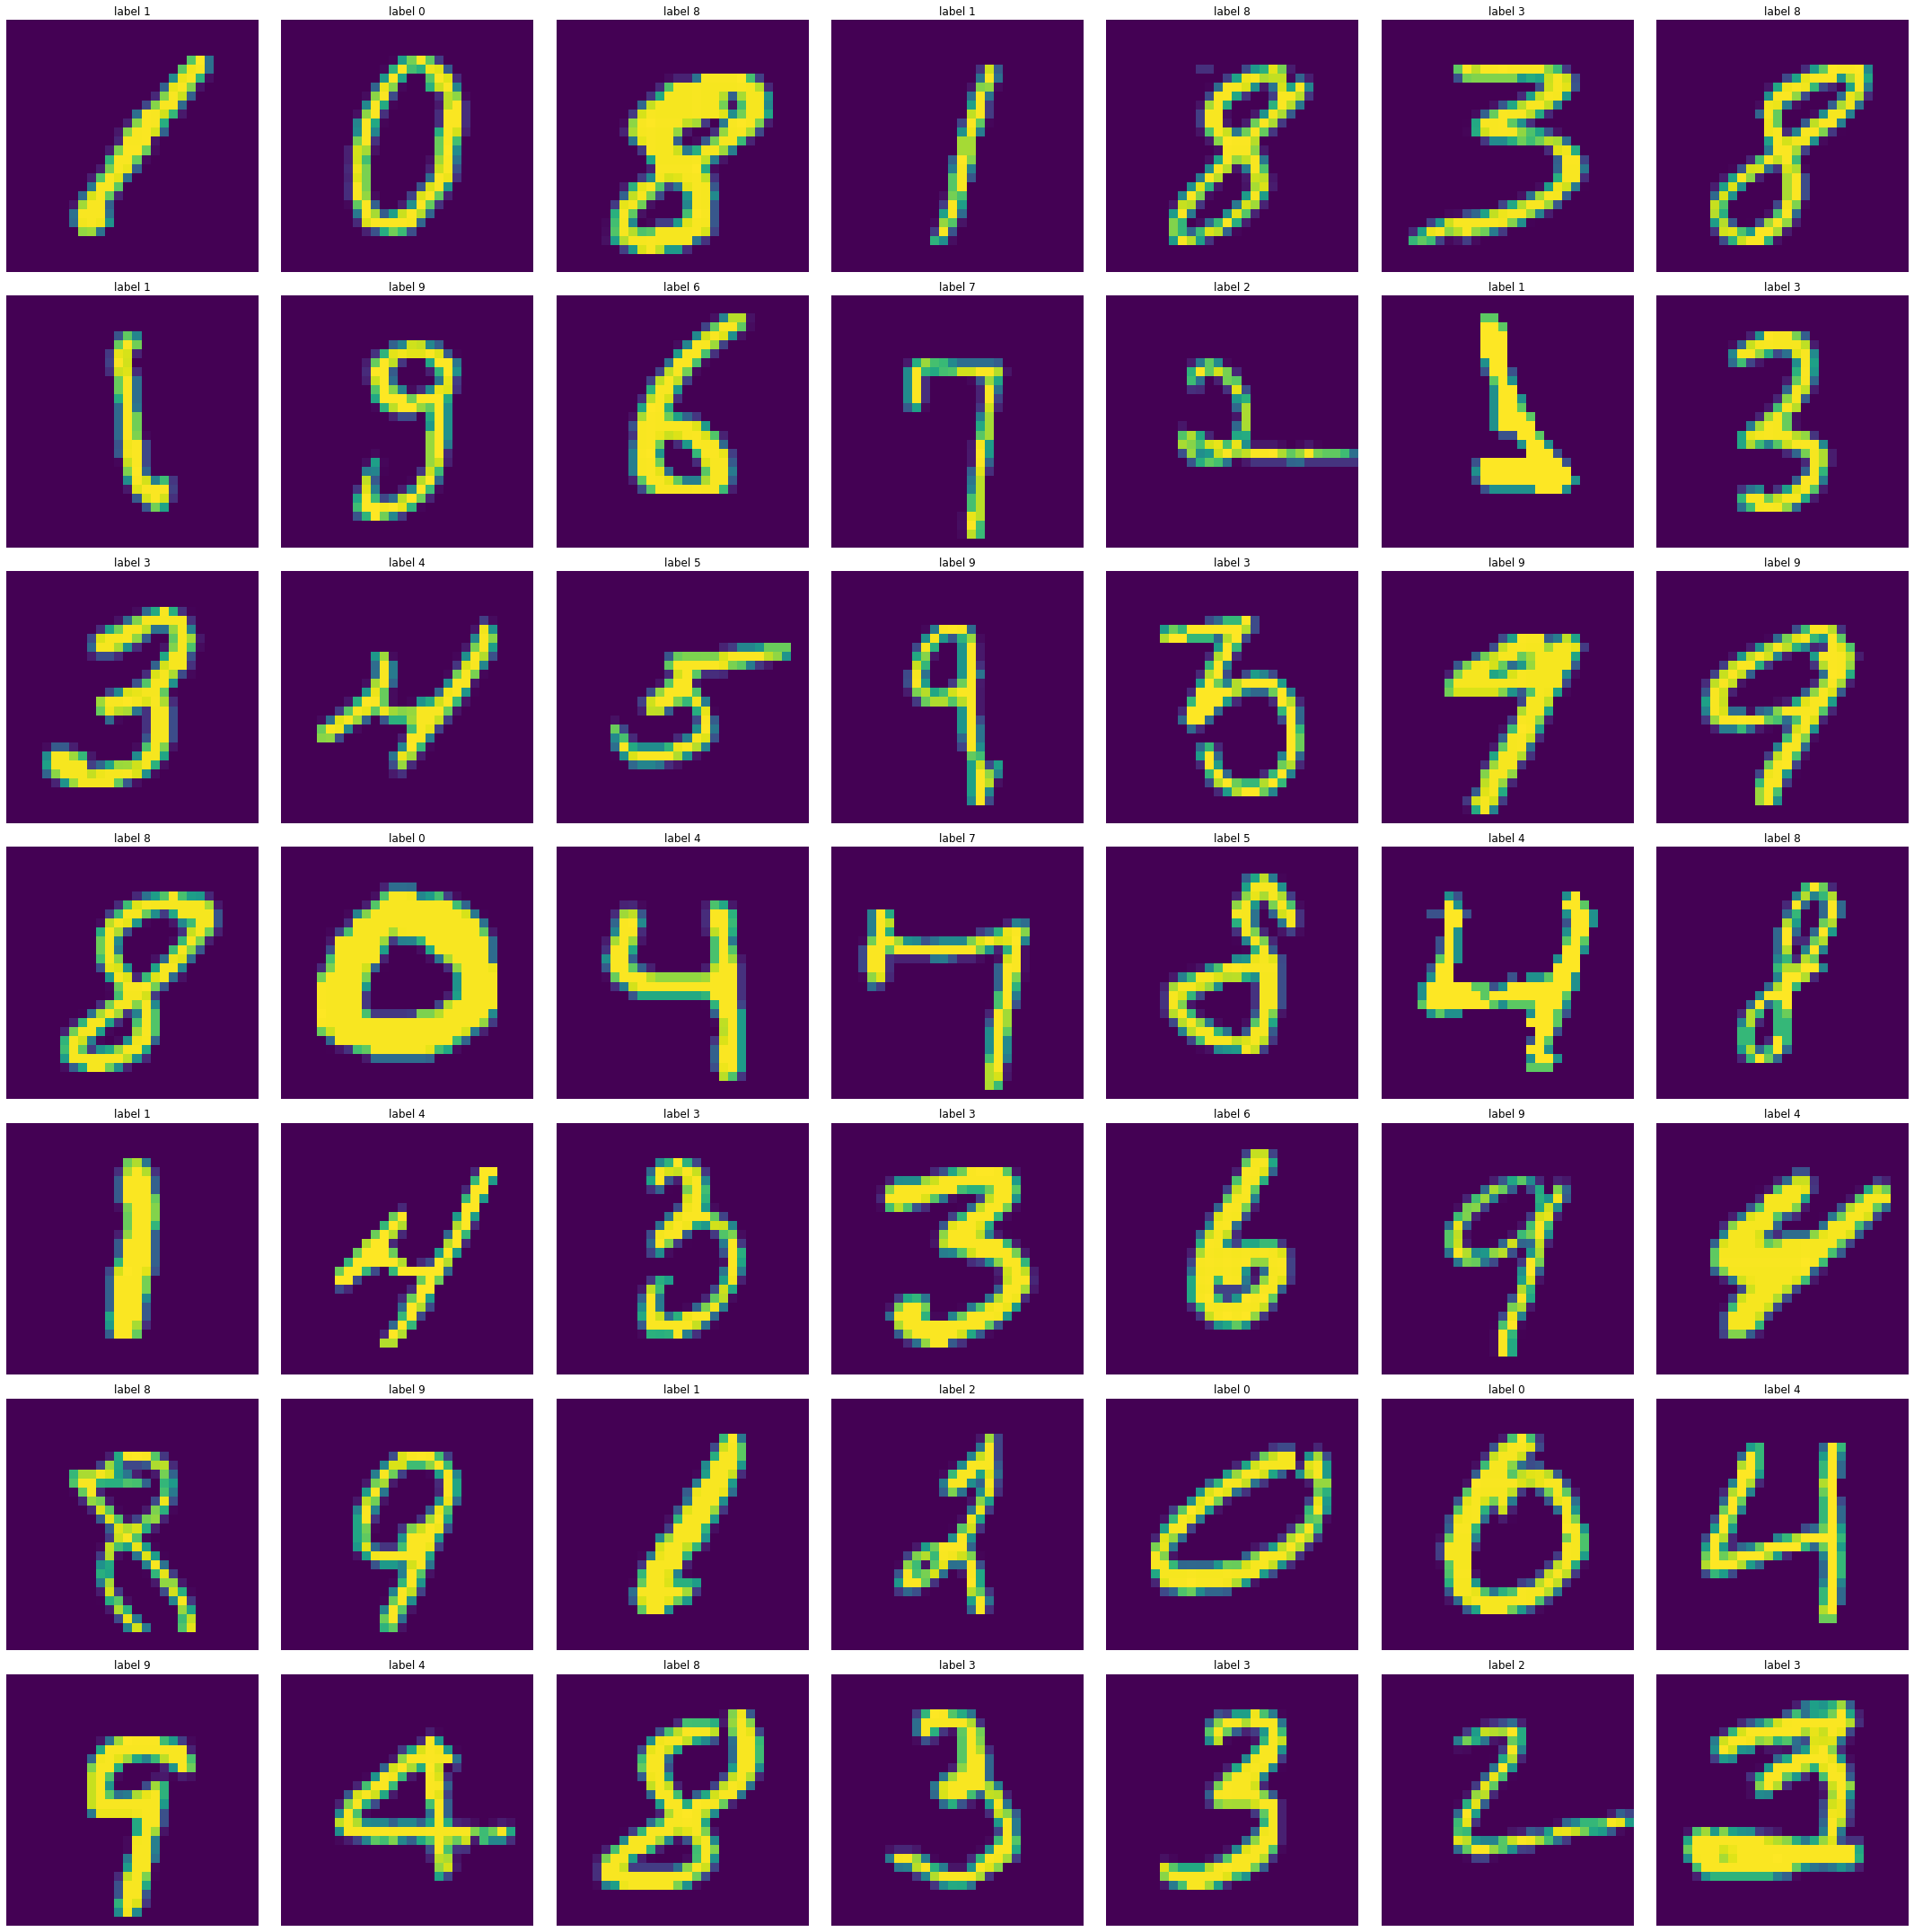

In [49]:
plt.figure(figsize=(30,30))
for i in range(0, 245, 5):
    plt.subplot(7, 7, i / 5 + 1)
    plt.axis("off")
    plt.title("label " + str(df_ori["label"][i]))
    plt.imshow(df_ori.iloc[i][1:].values.reshape(28,28))
plt.tight_layout()

由於在上列視覺化圖像中觀察到似乎有許多資料太細，邊緣有太多資料點的數值過低，認為可能不利於模型，於是使用gamma correction來調整
不過後來效果不彰，予以保留

In [50]:
df_train_x = df_ori.copy()
"""
def gamma(image, gamma=0.3):
    orig_shape = image.shape
    m = image.min()
    image = image - m
    r = image.max() - image.min()
    table = np.array([((i / float(r)) ** gamma) * r for i in np.arange(0, r + 1)])
    result = table[image]
    result = (result + m).astype(int)
    return result


for i in range(df_train_x.shape[0]):
    df_train_x.iloc[i][1:] = gamma(df_ori.iloc[i][1:])

plt.figure(figsize=(30,30))
for i in range(0, 245, 5):
    plt.subplot(7, 7, i / 5 + 1)
    plt.axis("off")
    plt.title("label " + str(df_train_x["label"][i]))
    df_train_x.iloc[i][1:] = gamma(df_ori.iloc[i][1:])
    plt.imshow(df_train_x.iloc[i][1:].values.reshape(28,28))
plt.tight_layout()
"""

'\ndef gamma(image, gamma=0.3):\n    orig_shape = image.shape\n    m = image.min()\n    image = image - m\n    r = image.max() - image.min()\n    table = np.array([((i / float(r)) ** gamma) * r for i in np.arange(0, r + 1)])\n    result = table[image]\n    result = (result + m).astype(int)\n    return result\n\n\nfor i in range(df_train_x.shape[0]):\n    df_train_x.iloc[i][1:] = gamma(df_ori.iloc[i][1:])\n\nplt.figure(figsize=(30,30))\nfor i in range(0, 245, 5):\n    plt.subplot(7, 7, i / 5 + 1)\n    plt.axis("off")\n    plt.title("label " + str(df_train_x["label"][i]))\n    df_train_x.iloc[i][1:] = gamma(df_ori.iloc[i][1:])\n    plt.imshow(df_train_x.iloc[i][1:].values.reshape(28,28))\nplt.tight_layout()\n'

試圖使用morphology and threshold去除雜訊未果

In [51]:
"""
import cv2 as cv
ker = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

plt.figure(figsize=(30,30))
for i in range(0, 245, 5):
    plt.subplot(7, 7, i / 5 + 1)
    plt.axis("off")
    plt.title("label " + str(df_train["label"][i]))
    df_train.iloc[i][1:] = cv.morphologyEx(df_train.iloc[i][1:].to_numpy().astype(np.float32).reshape(28, 28), cv.MORPH_OPEN, ker).reshape(784,)
    plt.imshow(df_train.iloc[i][1:].values.reshape(28,28))
plt.tight_layout()
"""

'\nimport cv2 as cv\nker = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))\n\nplt.figure(figsize=(30,30))\nfor i in range(0, 245, 5):\n    plt.subplot(7, 7, i / 5 + 1)\n    plt.axis("off")\n    plt.title("label " + str(df_train["label"][i]))\n    df_train.iloc[i][1:] = cv.morphologyEx(df_train.iloc[i][1:].to_numpy().astype(np.float32).reshape(28, 28), cv.MORPH_OPEN, ker).reshape(784,)\n    plt.imshow(df_train.iloc[i][1:].values.reshape(28,28))\nplt.tight_layout()\n'

# train model
使用cuda並開始訓練，建立一個線性卷積模型

In [52]:
import tensorflow as tf
from tensorflow import keras

In [53]:
import os

use_tpu = True #@param {type:"boolean"}


if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''


In [54]:
df_train_y = df_train_x["label"]
df_train_x.drop('label', axis=1, inplace=True)
print(df_train_y)
print(df_train_x)

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64
       pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0           0       0       0       0  ...         0         0         0         0
1           0       0       0       0  ...         0         0         0         0
2           0       0       0       0  ...         0         0         0         0
3           0       0       0       0  ...         0         0         0         0
4           0       0       0       0  ...         0         0         0         0
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
41995       0       0       0       0  ...         0         0         0         0
41996       0       0       0       0  ...         0         0         0         0
41997       0       0       0       0  ...         0         0         0         0
41998   

原先只有使用兩層卷積和一層pooling，發現效果怎麼試都不到95%，在kaggle上的排名會很低。後來便讓卷積和pooling都翻倍，同時因為資料縮太小後預測不精確，為了不讓這種情況發生，利用padding填補資料

In [55]:
batch_size = 800
num_classes = 10
epochs = 40

# 定義圖像寬、高
img_rows, img_cols = 28, 28

train_x = df_train_x.to_numpy().reshape(df_train_x.shape[0], img_rows, img_cols, 1)
train_y = df_train_y.to_numpy()
input_shape = (img_rows, img_cols, 1)

# 轉換色彩 0~255 資料為 0~1
train_x = train_x.astype('float32')
train_x /= 255

# y 值轉成 one-hot encoding
train_y = keras.utils.to_categorical(train_y, num_classes)

def get_model():
  # 建立簡單的線性執行的模型
  model = keras.Sequential()
  # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
  model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = "SAME"))

  # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding = "SAME"))

  # 建立池化層，池化大小=2x2，取最大值
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
  model.add(keras.layers.Dropout(0.25))

  # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding = "SAME"))

  # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding = "SAME"))

  # 建立池化層，池化大小=2x2，取最大值
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
  model.add(keras.layers.Dropout(0.25))

  # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
  model.add(keras.layers.Flatten())

  # 全連接層: 128個output
  model.add(keras.layers.Dense(128, activation='relu'))

  # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
  model.add(keras.layers.Dropout(0.5))

  # 使用 softmax activation function，將結果分類
  model.add(keras.layers.Dense(num_classes, activation='softmax'))
  return model

In [56]:
print(train_y)
print(df_train_y)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64


使用CUDA來加速運算

In [57]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.114.221.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.221.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


經過嘗試和網路查詢後，發現RMSprop最為適合作為optimizer

In [61]:
model = get_model()

#model = keras.models.load_model("/content/drive/MyDrive/Colab_Data/MNIST/model_98.h5")

# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.5, decay = 1e-6)

# 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss=keras.losses.categorical_crossentropy, optimizer = optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [62]:
# 進行訓練, 訓練過程會存在 train_history 變數中
train_history = model.fit(train_x, train_y,
          batch_size=batch_size * 8,
          epochs=epochs,
          verbose=1,
          validation_split= 0.2)

x_test, y_test = train_x[:8000], train_y[:8000]

# 顯示損失函數、訓練成果(分數)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/40
6/6 [==============================] - 8s 1s/step - loss: 2.2197 - accuracy: 0.2477 - val_loss: 1.5203 - val_accuracy: 0.7023
Epoch 2/40
6/6 [==============================] - 6s 1s/step - loss: 1.5179 - accuracy: 0.5679 - val_loss: 0.6106 - val_accuracy: 0.8173
Epoch 3/40
6/6 [==============================] - 6s 983ms/step - loss: 0.8612 - accuracy: 0.7276 - val_loss: 0.6631 - val_accuracy: 0.7787
Epoch 4/40
6/6 [==============================] - 6s 888ms/step - loss: 0.6363 - accuracy: 0.7988 - val_loss: 0.4006 - val_accuracy: 0.8836
Epoch 5/40
6/6 [==============================] - 5s 840ms/step - loss: 0.4635 - accuracy: 0.8562 - val_loss: 0.2620 - val_accuracy: 0.9273
Epoch 6/40
6/6 [==============================] - 5s 844ms/step - loss: 0.3673 - accuracy: 0.8876 - val_loss: 0.3154 - val_accuracy: 0.9112
Epoch 7/40
6/6 [==============================] - 5s 836ms/step - loss: 0.3769 - accuracy: 0.8816 - val_loss: 0.1651 - val_accuracy: 0.9479
Epoch 8/40
6/6 [==========

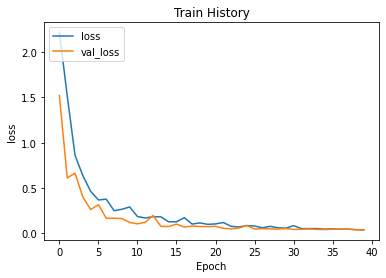

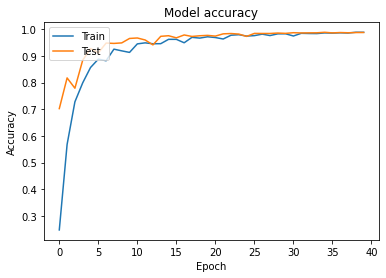

In [63]:
plt.plot(train_history.history['loss'])  
plt.plot(train_history.history['val_loss'])  
plt.title('Train History')  
plt.ylabel('loss')  
plt.xlabel('Epoch')  
plt.legend(['loss', 'val_loss'], loc='upper left')  
plt.show() 

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [76]:
#model.save("/content/drive/MyDrive/Colab_Data/MNIST/model_1.h5")

#預測資料
儲存模型後對kaggle所給的無標記資料進行預測，放到kaggle上測試後目前模型的準確率為0.98789，約為40%

In [64]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab_Data/MNIST/test.csv")

df_test.iloc[0].describe()


count    784.000000
mean      50.260204
std       94.217100
min        0.000000
25%        0.000000
50%        0.000000
75%       17.000000
max      255.000000
Name: 0, dtype: float64

In [65]:
test_x = df_test.to_numpy().reshape(df_test.shape[0], 28, 28, 1)

# 轉換色彩 0~255 資料為 0~1
test_x = df_test.to_numpy().astype('float32')
test_x /= 255

test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)

In [66]:
test_x.shape

(28000, 28, 28, 1)

In [67]:
predictions = model.predict(test_x)
#predictions = model.predict_classes(test_x) 
#pd.crosstab(y_test_org, predictions, rownames=['實際值'], colnames=['預測值'])

In [83]:
df_ans = pd.DataFrame(columns = ["ImageId", "Label"])
predictions.shape

(28000,)

In [69]:
predictions = np.argmax(predictions, axis=1)

In [85]:
for i, ans in enumerate(predictions):
  df_ans = df_ans.append({"ImageId": i + 1, "Label": ans}, ignore_index=True)

In [86]:
df_ans

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


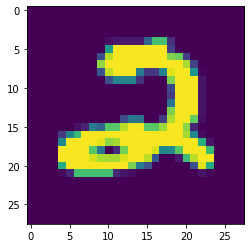

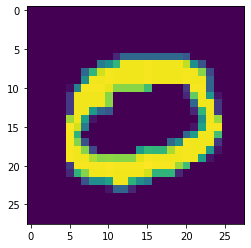

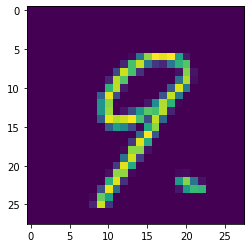

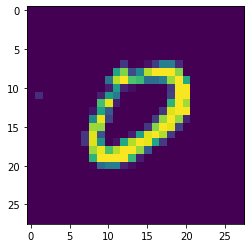

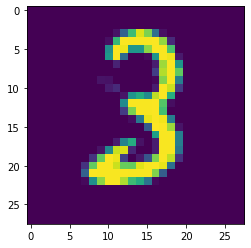

In [81]:
p = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
for i in range(5):
  plt.imshow(p[i])
  plt.show()

In [87]:
df_ans.to_csv("ansWithModel1.csv", index=False)